In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import theano
import matplotlib.pyplot as plt

This data set explores diabetes in the pima indian population. The features included are the number of times pregnant, glucose concentration, blood pressure, insulin level, BMI, pedigree and age. The feature 'group' is a faux feature and is not included in the set.

In [2]:
#Read data using pandas and drop the 'group' feature
DiabetesData = pd.read_csv("pima-indians-diabetes.csv")
DiabetesData = DiabetesData.drop(['Group'], axis = 1)
#DiabetesData = DiabetesData.drop(['Triceps'], axis = 1)
#Output the yes/no value of diabetes diagnosis
y = DiabetesData['Class'].values
DiabetesData = DiabetesData.drop(['Class'], axis = 1)

#Get the features and since we are using linear regression, we scale the numerical features so one doesn't overpower the
#others
x = DiabetesData.values 
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

DiabetesData.head(7)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33
5,5,0.582915,0.606557,0.000000,0.000000,0.381520,0.052519,30
6,3,0.391960,0.409836,0.323232,0.104019,0.461997,0.072588,26


In [3]:
#Splitting into training and testing sets
NumberOfFeatures = x.shape[1]
print ("Number of features: ", NumberOfFeatures)
print ("Number of data points: ", x.shape[0])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print ("Number of training data points: ", X_train.shape[0])
print ("Number of test data points: ", X_test.shape[0])

Number of features:  8
Number of data points:  768
Number of training data points:  614
Number of test data points:  154


In [4]:
NumberOfPoints = x.shape[0]
print ("Number of training data points: ", NumberOfPoints)
X_ = theano.shared(X_train)
Y_ = theano.shared(y_train)

Number of training data points:  768


In [5]:
#We now construct our linear model
def ConstructModel(X, Y, NoF, NoP):
    print ("Number of features: ", NoF)
    print ("Number of data points: ", NoP)
    print ("x shape: ", X.eval().shape)
    print ("y shape: ", Y.eval().shape)
    
    with pm.Model() as DiabetesModel:
        #We use normal priors for the intercept and slopes. The combination of which results in the log odds
        Slope = pm.Normal('Slope', mu=1., sd=10., shape = (NoF))
        Intercept = pm.Normal('Intercept', mu=1., sd=10)

        LogOdds = tt.dot(X, Slope) + Intercept 
        
        #This is the Bernoulli probability with the logistic function
        Prob = pm.Deterministic("p", 1./(1+tt.exp(-LogOdds)))

        #The likelihood is the Bernoulli likelihood with the above probabilities and the observed diabetes diagnosis
        Output = pm.Bernoulli("Prob", p = Prob, observed = Y)
    return DiabetesModel

In [6]:
#Constructing the model
DiabetesModel = ConstructModel(X_, Y_, NumberOfFeatures, NumberOfPoints)

Number of features:  8
Number of data points:  768
x shape:  (614, 8)
y shape:  (614,)


In [7]:
#We next sample the model using the No-U-Turn sampler(NUTS)
with DiabetesModel:
    trace = pm.sample(10000, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Slope]
100%|██████████| 10500/10500 [01:28<00:00, 118.70it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Text(0.5,1,'BFMI = 1.0492313884478486\nGelman-Rubin = 1.0001203589584051')

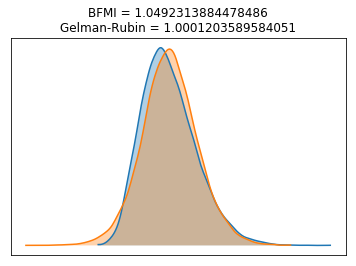

In [8]:
#We want the Gelmin-Rubin statistic to be close to one to indicate convergence. The Bayesian fraction of missing
#information(BMFI) should be above 0.2.
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)))

In [9]:
#Shows the mean values and uncertainties of the stochastic variables
pm.summary(trace, varnames = ['Slope', 'Intercept'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Slope__0,1.101842,0.620563,0.004306,-0.134765,2.301121,18404.0,0.999980
Slope__1,6.847379,0.838392,0.006196,5.197546,8.497030,14516.0,0.999989
Slope__2,-1.717948,0.761382,0.005244,-3.223668,-0.266379,20000.0,0.999959
Slope__3,0.311976,0.776704,0.006381,-1.207402,1.799551,14706.0,0.999995
Slope__4,-1.509237,0.862940,0.007000,-3.217436,0.155663,13358.0,1.000013
Slope__5,6.905164,1.141415,0.009700,4.667328,9.121687,15018.0,0.999989
Slope__6,1.657477,0.774573,0.004264,0.148841,3.164588,20000.0,0.999951
Slope__7,2.257975,0.661000,0.005102,0.947082,3.542124,16358.0,0.999954
Intercept,-8.257509,0.783928,0.006429,-9.785137,-6.715547,12904.0,1.000036


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122609c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122515a90>]], dtype=object)

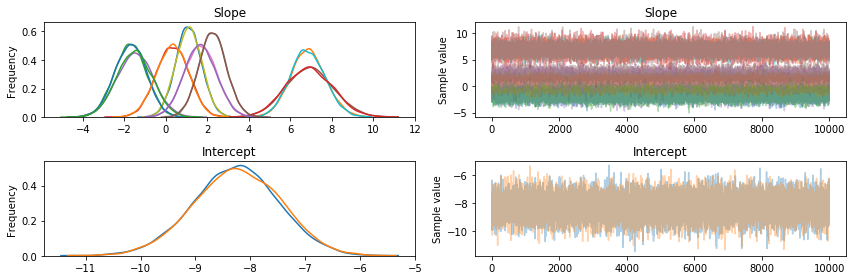

In [10]:
#Graphical visual of above information
pm.traceplot(trace, varnames = ['Slope', 'Intercept'])

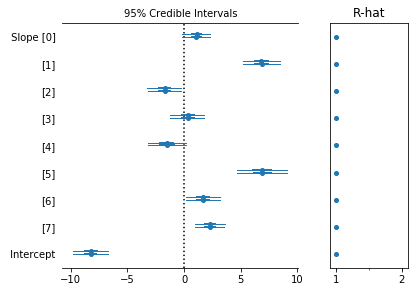

In [11]:
#This shows the 95% credible intervals of each parameter. We see that zero is within the 95% credible interval of the 
#triceps feature showing that this feature might not be relevant. We will test this later.

pm.forestplot(trace, varnames = ['Slope', 'Intercept'])

In [12]:
#Lets now calculate the accuracy on the test set.
Slope_Samples = trace['Slope'].T
Intercept_Samples = trace['Intercept'].T
Mean = tt.dot(X_test, Slope_Samples) + Intercept_Samples
Probabilities = 1./(1+tt.exp(-Mean))
MeanProbabilities = np.mean(Probabilities.eval(), axis = 1)
Pred = MeanProbabilities > 0.65

print('Accuracy = {}%'.format((y_test == Pred).mean() * 100))   
#Not bad!

Accuracy = 79.22077922077922%


Now let's test if the triceps feature is relevant. Do do this we construct a different model without this feature:

In [13]:
DiabetesData = DiabetesData.drop(['Triceps'], axis = 1)
x = DiabetesData.values 
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

DiabetesData.head(7)

,Number_pregnant,Glucose_concentration,Blood_pressure,Insulin,BMI,Pedigree,Age
0,6,0.743719,0.590164,0.000000,0.500745,0.234415,50
1,1,0.427136,0.540984,0.000000,0.396423,0.116567,31
2,8,0.919598,0.524590,0.000000,0.347243,0.253629,32
3,1,0.447236,0.540984,0.111111,0.418778,0.038002,21
4,0,0.688442,0.327869,0.198582,0.642325,0.943638,33
5,5,0.582915,0.606557,0.000000,0.381520,0.052519,30
6,3,0.391960,0.409836,0.104019,0.461997,0.072588,26


In [14]:
#Splitting into training and testing sets
NumberOfFeatures = x.shape[1]
print ("Number of features: ", NumberOfFeatures)
print ("Number of data points: ", x.shape[0])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print ("Number of training data points: ", X_train.shape[0])
print ("Number of test data points: ", X_test.shape[0])

NumberOfPoints = X_train.shape[0]
X_ = theano.shared(X_train)
Y_ = theano.shared(y_train)

Number of features:  7
Number of data points:  768
Number of training data points:  614
Number of test data points:  154


In [15]:
#Constructing the model
DiabetesModel1 = ConstructModel(X_, Y_, NumberOfFeatures, NumberOfPoints)

Number of features:  7
Number of data points:  614
x shape:  (614, 7)
y shape:  (614,)


In [16]:
#sampling
with DiabetesModel1:
    trace1 = pm.sample(10000, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Slope]
100%|██████████| 10500/10500 [01:29<00:00, 117.56it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


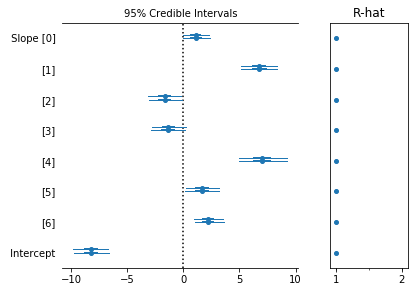

In [21]:
pm.forestplot(trace1, varnames = ['Slope', 'Intercept'])

In [17]:
#Lets now calculate the accuracy on the test set.
Slope_Samples = trace1['Slope'].T
Intercept_Samples = trace1['Intercept'].T
Mean = tt.dot(X_test, Slope_Samples) + Intercept_Samples
Probabilities = 1./(1+tt.exp(-Mean))
MeanProbabilities = np.mean(Probabilities.eval(), axis = 1)
Pred = MeanProbabilities > 0.65

print('Accuracy = {}%'.format((y_test == Pred).mean() * 100))   

Accuracy = 79.22077922077922%


In [19]:
#Comparing the widely-applicable information criterion to both models. The first column is the waic score
#(lower is better!), the second is the effective number of parameters, 
#the third is the relative difference in score between the lowest and the other models, the fourth column
#is the Akaike weights should we like to average results of the two models, dSE is the standard relative error
#between the two. We see that the higher parameter version yields no better score relative to the error so we remove
#the triceps feature according to this criterion
df_comp_WAIC = pm.compare((trace, trace1), (DiabetesModel, DiabetesModel1))
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,592.18,9.24,0,1,27.84,0,1
0,593.95,10.23,1.77,0,27.88,0.83,1


In [20]:
#The WAIC calculation might be unstable as the warning in the last column above shows so we use approximate leave-one-out
#validation insetead which is shown to be more robust in some instances. Here we also see the non-tricepts model
#having the same predictive power as the tricepts model. We can therefore conclude that the tricepts feature is not
#significant 
df_comp_LOO = pm.compare((trace, trace1), (DiabetesModel, DiabetesModel1), ic = 'LOO')
df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
1,592.2,9.24,0,1,27.84,0,0
0,593.97,10.23,1.77,0,27.88,0.83,0
